#i***mport libraries***

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [4]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# load vgg16 model

In [5]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

I0000 00:00:1763128026.041119      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763128026.041956      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


# extract features from image

In [6]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1763128040.645430     112 service.cc:148] XLA service 0x7fdd38005670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763128040.646286     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763128040.646303     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763128040.800157     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763128043.427227     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# store features in pickle


In [7]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

# load features from pickle

In [8]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [10]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

In [38]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
        # preprocessing steps
        # convert to lowercase
            caption = caption.lower()
        # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
            caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + 'endseq'
            captions[i] = caption

In [40]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['<start_seq> child in pink dress is climbing up set of stairs in an entry way<end_seq>',
 '<start_seq> girl going into wooden building<end_seq>',
 '<start_seq> little girl climbing into wooden playhouse<end_seq>',
 '<start_seq> little girl climbing the stairs to her playhouse<end_seq>',
 '<start_seq> little girl in pink dress going into wooden cabin<end_seq>']

In [42]:
# preprocess the text
clean(mapping)

In [43]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq <start_seq> child in pink dress is climbing up set of stairs in an entry way<end_seq>endseq',
 'startseq <start_seq> girl going into wooden building<end_seq>endseq',
 'startseq <start_seq> little girl climbing into wooden playhouse<end_seq>endseq',
 'startseq <start_seq> little girl climbing the stairs to her playhouse<end_seq>endseq',
 'startseq <start_seq> little girl in pink dress going into wooden cabin<end_seq>endseq']

In [45]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [46]:
len(all_captions)

40455

In [48]:
all_captions[:10]

['startseq <start_seq> child in pink dress is climbing up set of stairs in an entry way<end_seq>endseq',
 'startseq <start_seq> girl going into wooden building<end_seq>endseq',
 'startseq <start_seq> little girl climbing into wooden playhouse<end_seq>endseq',
 'startseq <start_seq> little girl climbing the stairs to her playhouse<end_seq>endseq',
 'startseq <start_seq> little girl in pink dress going into wooden cabin<end_seq>endseq',
 'startseq <start_seq> black dog and spotted dog are fighting<end_seq>endseq',
 'startseq <start_seq> black dog and tri-colored dog playing with each other on the road<end_seq>endseq',
 'startseq <start_seq> black dog and white dog with brown spots are staring at each other in the street<end_seq>endseq',
 'startseq <start_seq> two dogs of different breeds looking at each other on the road<end_seq>endseq',
 'startseq <start_seq> two dogs on pavement moving toward each other<end_seq>endseq']

In [49]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [50]:
vocab_size

8486

In [51]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [53]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [54]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

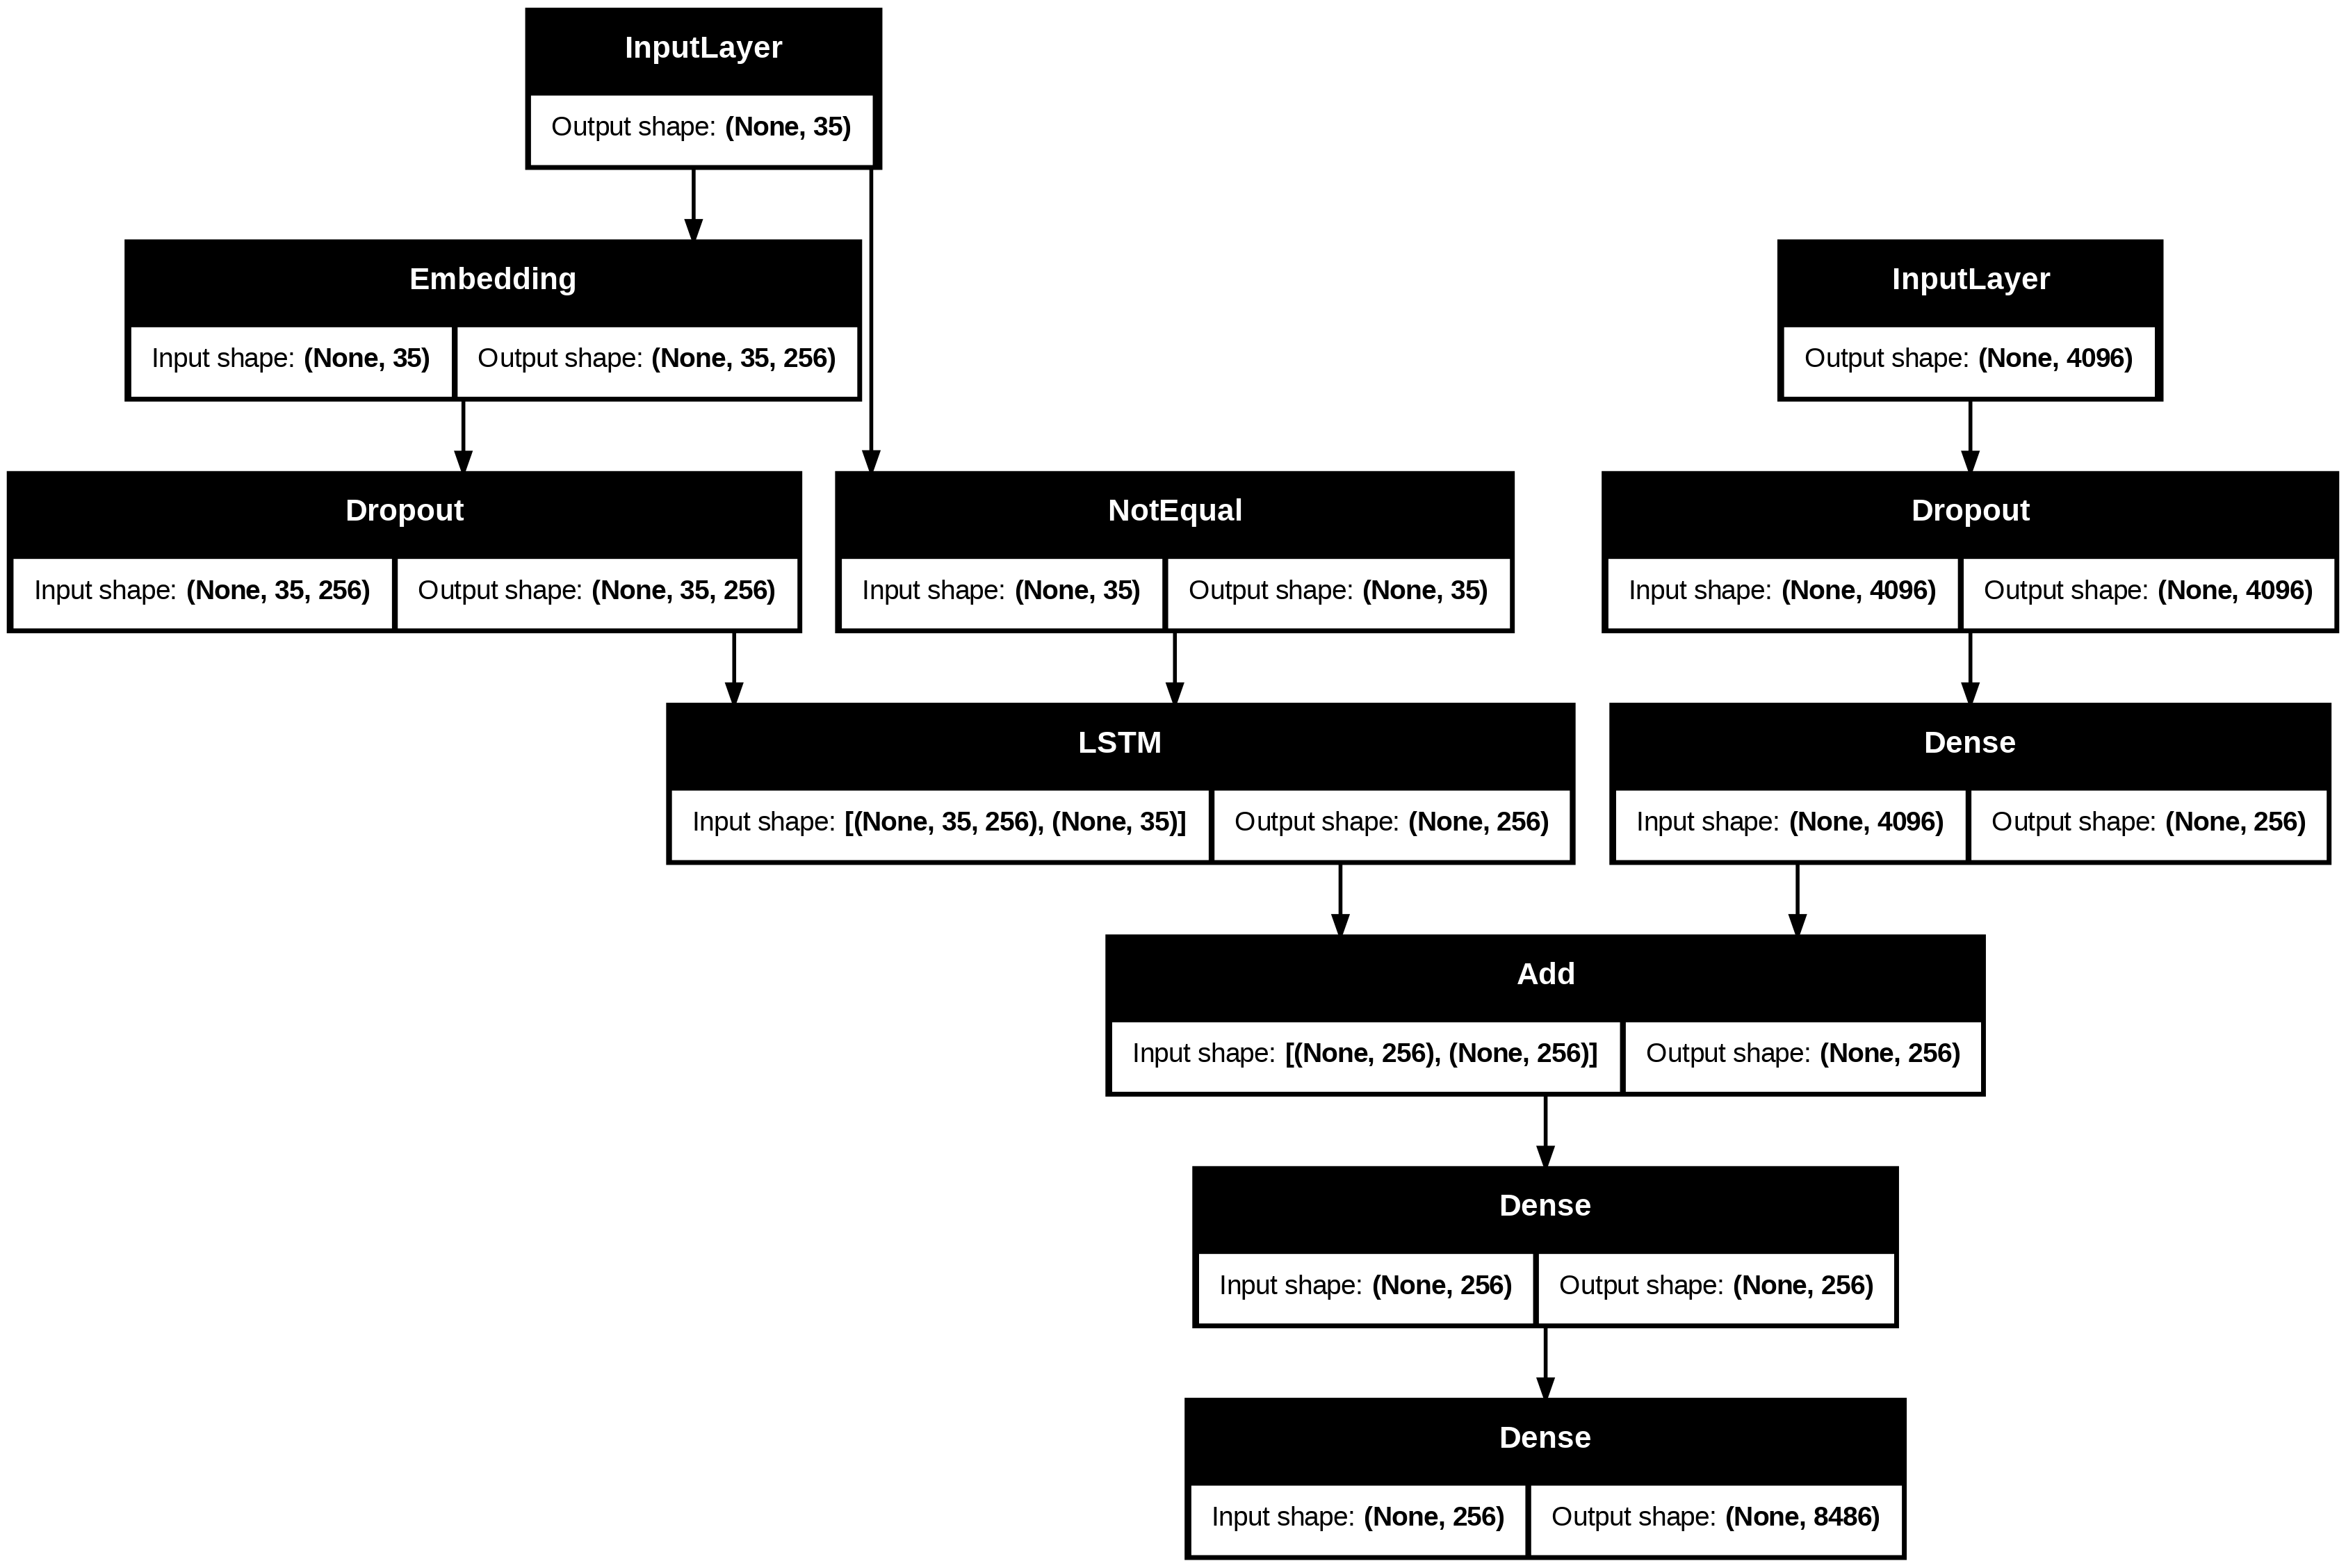

In [55]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [56]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 82s 352ms/step - loss: 4.7047
227/227 ━━━━━━━━━━━━━━━━━━━━ 78s 344ms/step - loss: 2.9711
227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 347ms/step - loss: 2.6138
227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 347ms/step - loss: 2.4054
227/227 ━━━━━━━━━━━━━━━━━━━━ 78s 343ms/step - loss: 2.2580
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 354ms/step - loss: 2.1468
227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 338ms/step - loss: 2.0658
227/227 ━━━━━━━━━━━━━━━━━━━━ 81s 356ms/step - loss: 1.9967
227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 348ms/step - loss: 1.9406
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 353ms/step - loss: 1.8884
227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 349ms/step - loss: 1.8415
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 354ms/step - loss: 1.7996
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 353ms/step - loss: 1.7665
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 352ms/step - loss: 1.7312
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 351ms/step - loss: 1.7028
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 352ms/step - loss: 1.6771
227/227 ━━━━━━━━━━━━━━━━━━━━ 79s 350ms/step - loss: 1.65

In [57]:
# save the model
model.save(WORKING_DIR+'/best_model.keras')

In [59]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
        return None

In [83]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [84]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.000335
BLEU-2: 0.000000
BLEU-1: 0.002479
BLEU-2: 0.000000
BLEU-1: 0.001273
BLEU-2: 0.000000
BLEU-1: 0.001503
BLEU-2: 0.000000
BLEU-1: 0.000912
BLEU-2: 0.000000
BLEU-1: 0.000912
BLEU-2: 0.000000
BLEU-1: 0.001052
BLEU-2: 0.000000
BLEU-1: 0.001033
BLEU-2: 0.000000
BLEU-1: 0.001019
BLEU-2: 0.000000
BLEU-1: 0.000611
BLEU-2: 0.000000
BLEU-1: 0.000694
BLEU-2: 0.000000
BLEU-1: 0.000772
BLEU-2: 0.000000
BLEU-1: 0.000782
BLEU-2: 0.000000
BLEU-1: 0.000790
BLEU-2: 0.000000
BLEU-1: 0.000912
BLEU-2: 0.000000
BLEU-1: 0.000912
BLEU-2: 0.000000
BLEU-1: 0.000811
BLEU-2: 0.000000
BLEU-1: 0.000863
BLEU-2: 0.000000
BLEU-1: 0.000961
BLEU-2: 0.000000
BLEU-1: 0.000867
BLEU-2: 0.000000
BLEU-1: 0.001003
BLEU-2: 0.000000
BLEU-1: 0.001045
BLEU-2: 0.000000
BLEU-1: 0.001039
BLEU-2: 0.000000
BLEU-1: 0.000991
BLEU-2: 0.000000
BLEU-1: 0.000988
BLEU-2: 0.000000
BLEU-1: 0.000985
BLEU-2: 0.000000
BLEU-1: 0.000946
BLEU-2: 0.000000
BLEU-1: 0.000945
BLEU-2: 0.000000
BLEU-1: 0.000944
BLEU-2: 0.000000
BLEU-1: 0.0009

In [85]:
def clean_caption(caption):
    words = caption.split()
    clean_words = [w for w in words if w not in ['startseq', 'endseq']]
    return''.join(clean_words)

In [101]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print("Predicted Caption:", caption)
    plt.imshow(image)


---------------------Actual---------------------
startseq <start_seq> man lays on bench while his dog sits by him<end_seq>endseq
startseq <start_seq> man lays on the bench to which white dog is also tied<end_seq>endseq
startseq <start_seq> man sleeping on bench outside with white and black dog sitting next to him<end_seq>endseq
startseq <start_seq> shirtless man lies on park bench with his dog<end_seq>endseq
startseq <start_seq> man laying on bench holding leash of dog sitting on ground<end_seq>endseq
--------------------Predicted--------------------
Predicted Caption: startseq <start_seq> man laying on bench holding leash of dog sitting on ground<end_seq>endseq


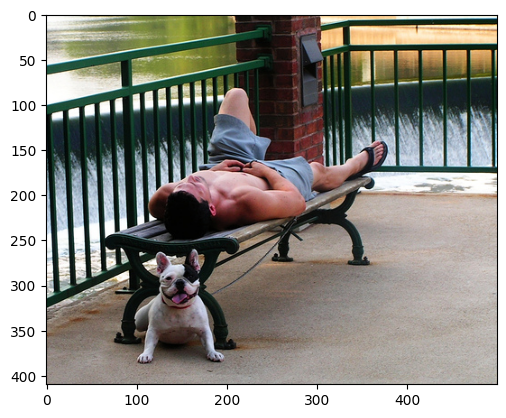

In [102]:
generate_caption("1003163366_44323f5815.jpg")

---------------------Actual---------------------
startseq <start_seq> little girl covered in paint sits in front of painted rainbow with her hands in bowl<end_seq>endseq
startseq <start_seq> little girl is sitting in front of large painted rainbow<end_seq>endseq
startseq <start_seq> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it<end_seq>endseq
startseq <start_seq> there is girl with pigtails sitting in front of rainbow painting<end_seq>endseq
startseq <start_seq> young girl with pigtails painting outside in the grass<end_seq>endseq
--------------------Predicted--------------------
Predicted Caption: startseq <start_seq> young girl with pigtails painting outside in the grass<end_seq>endseq


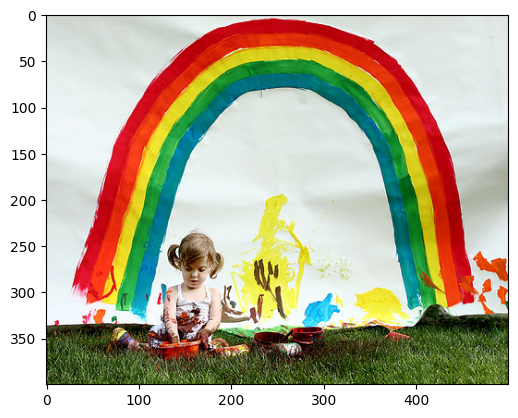

In [103]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq <start_seq> man in hat is displaying pictures next to skier in blue hat<end_seq>endseq
startseq <start_seq> man skis past another man displaying paintings in the snow<end_seq>endseq
startseq <start_seq> person wearing skis looking at framed pictures set up in the snow<end_seq>endseq
startseq <start_seq> skier looks at framed pictures in the snow next to trees<end_seq>endseq
startseq <start_seq> man on skis looking at artwork for sale in the snow<end_seq>endseq
--------------------Predicted--------------------
Predicted Caption: startseq <start_seq> man on skis looking at artwork for sale in the snow<end_seq>endseq


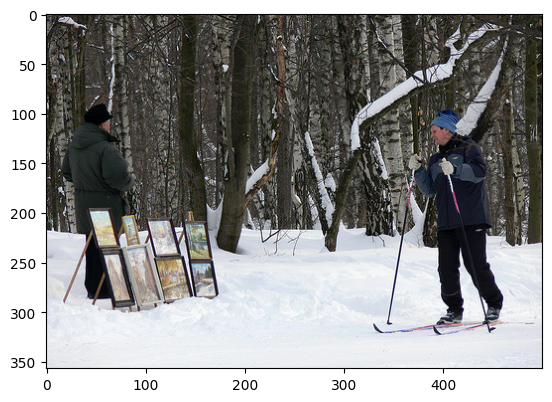

In [104]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [105]:
vgg_model = VGG16() 
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [106]:
image_path = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


'startseq'

---------------------Actual---------------------
startseq <start_seq> man drilling hole in the ice<end_seq>endseq
startseq <start_seq> man is drilling through the frozen ice of pond<end_seq>endseq
startseq <start_seq> person in the snow drilling hole in the ice<end_seq>endseq
startseq <start_seq> person standing on frozen lake<end_seq>endseq
startseq <start_seq> two men are ice fishing<end_seq>endseq
--------------------Predicted--------------------
Predicted Caption: startseq <start_seq> two men are ice fishing<end_seq>endseq


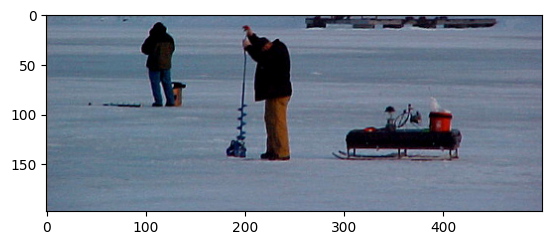

In [107]:
generate_caption("102351840_323e3de834.jpg")